In [1]:
#Testing so that for once and for all we can be sure that these three fundemental parts of our program are fucntioning 
# and to decipher how they should be applied 
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

In [2]:
def custom_normalisation(data, reconstruction_threshold, time_dimension=100):
    data = ((data / time_dimension) / (1/(1-reconstruction_threshold))) + reconstruction_threshold
    for row in data:
        for i, ipt in enumerate(row):
            if ipt == reconstruction_threshold:
                row[i] = 0
    return data

In [3]:
def custom_renormalisationNEW(data, reconstruction_threshold, time_dimension=100):
    data = np.where(data > reconstruction_threshold, ((data - reconstruction_threshold)*(1/(1-reconstruction_threshold)))*(time_dimension), 0)
    return data

In [4]:
def reconstruct_3DNEW(data, reconstruction_threshold):
    data_output = []
    for cdx, row in enumerate(data):
        for idx, num in enumerate(row):
            if num >= 1:  #should this be larger than or equal to??? depends how we deal with the 0 slice problem
                data_output.append([cdx,idx,num])
    return np.array(data_output)

In [5]:
def reconstruct_3D2(data, reconstruction_threshold):
    data_output = []
    for cdx, row in enumerate(data):
        for idx, num in enumerate(row):
            if num > reconstruction_threshold:  #should this be larger than or equal to??? depends how we deal with the 0 slice problem
                num_renorm = custom_renormalisation(num)
                data_output.append([cdx,idx,num_renorm])
    return np.array(data_output)

In [6]:
def plot_array(arr, title=""):
    if arr.ndim == 4: 
        # remove the first two dimensions (batch and channel) using slicing and reshape
        arr = arr.detach().squeeze(0).squeeze(0).float()
    fig, ax = plt.subplots()
    im = ax.imshow(arr)
    
    # Add the numerical values as text annotations
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            text = ax.text(j, i, arr[i, j], ha="center", va="center", color="w")

    # Add a colorbar to the plot
    cbar = ax.figure.colorbar(im, ax=ax)
    fig.suptitle(title)
    # Show the plot
    plt.show()


# Below I construct the signal path for the AE

In [7]:
def value_flow_test(in_array, reconstruction_threshold = 0.5, time_dimension = 100):
    """
    accurate (oterh than dtype and the ReLu activation fucntions) flow of data through the networks normalisations
    
    """
    #Input data
    plot_array(in_array, "INPUT")
    
    #Custom normalistion
    cnorm_array = custom_normalisation(in_array, reconstruction_threshold, time_dimension)
    plot_array(cnorm_array, "CUSTOM NORM")
    
    # Conversion of the NumPy array to a PyTorch tensor
    transform = transforms.ToTensor()
    cnorm_tensor = transform(cnorm_array)
    # Add extra dimensions of size 0 to the beginning to simulate the batch dim
    cnorm_tensor = cnorm_tensor.unsqueeze(0)
    #NEEDED TO CHANGE DTYPE? BUT THIS IS NOT MIRRORED IN MAIN CODE, IS THIS TO DO WITH MAIN CODE USING DOUBLE PRESICION?
    cnorm_tensor = cnorm_tensor.to(torch.bfloat16)
    plot_array(cnorm_tensor, "TO TENSOR")

    #Internal network batch normalisation
    m = torch.nn.BatchNorm2d(1)
    bnorm_cnorm_tensor = m(cnorm_tensor)
    plot_array(bnorm_cnorm_tensor, "BATCH NORM")

    #Network output sigmoid activation funct
    net_out = torch.sigmoid(bnorm_cnorm_tensor)
    plot_array(net_out, "SIGMOID")

    #Network output converted back to numpy array
    net_result = net_out.detach().squeeze(0).squeeze(0).float().numpy()
    plot_array(net_result, "TO NUMPY")

    #Renormalisation
    renorm_data = custom_renormalisationNEW(net_result, reconstruction_threshold, time_dimension)
    plot_array(renorm_data, "RENORM")

    #3D Reconstruction
    renorm_data_3d = reconstruct_3DNEW(renorm_data, reconstruction_threshold)
    plot_array(renorm_data_3d, "3D RECONSTRUCTION")

    #Reconstructing raw input for comparison
    input_3d_verification = reconstruct_3DNEW(in_array, reconstruction_threshold)
    plot_array(input_3d_verification, "RAW INPUT 3D RECONSTRUCTION")

    #Plot input vs output
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
    ax1.scatter(input_3d_verification[:,0], input_3d_verification[:,1], input_3d_verification[:,2])
    ax1.set_zlim(0, time_dimension)
    ax2.scatter(renorm_data_3d[:,0], renorm_data_3d[:,1], renorm_data_3d[:,2])
    ax2.set_zlim(0, time_dimension)
    fig.suptitle("3D Reconstruction")
    plt.show()
    
    


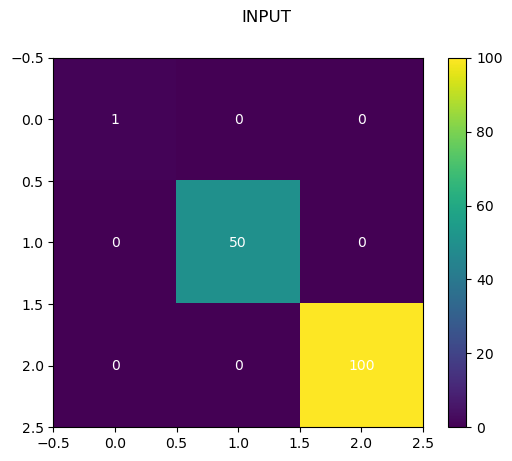

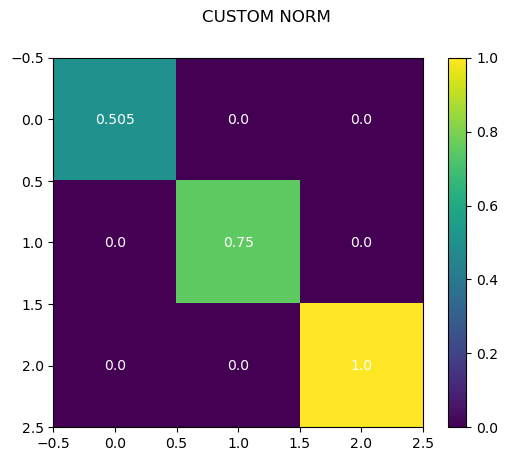

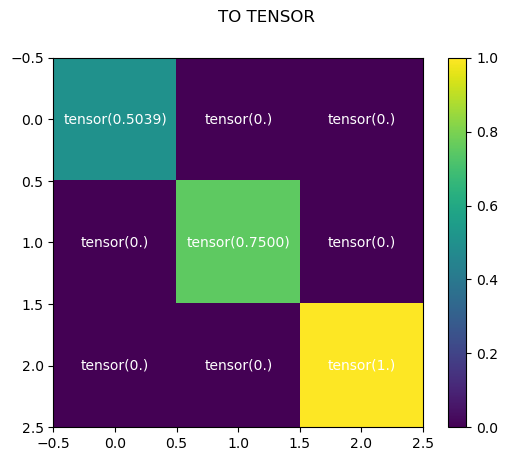

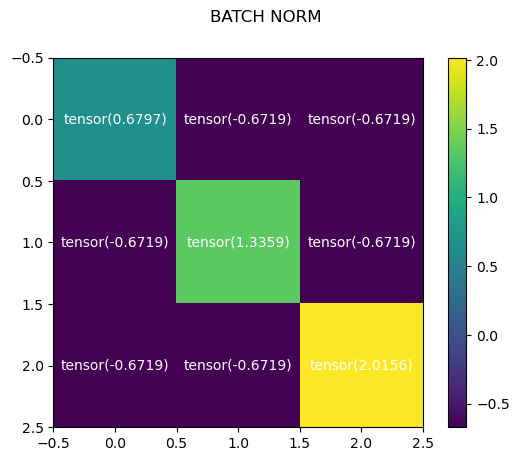

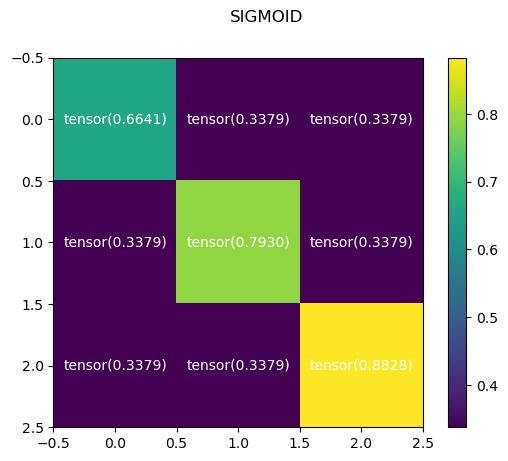

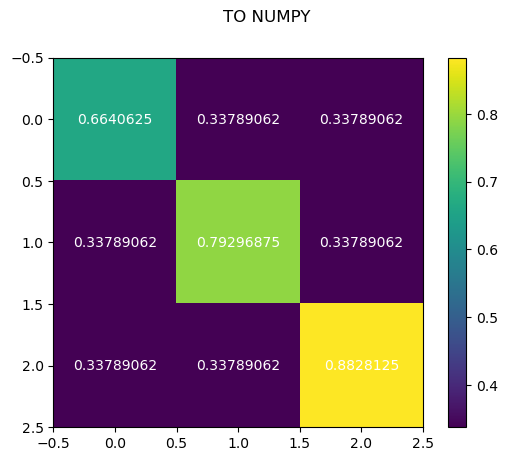

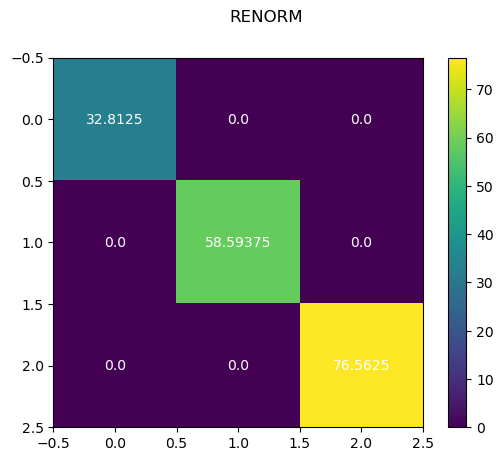

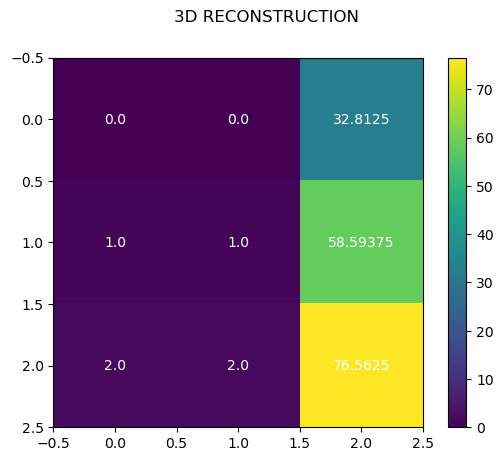

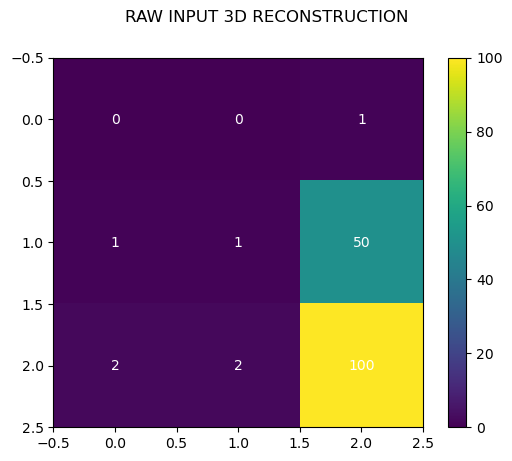

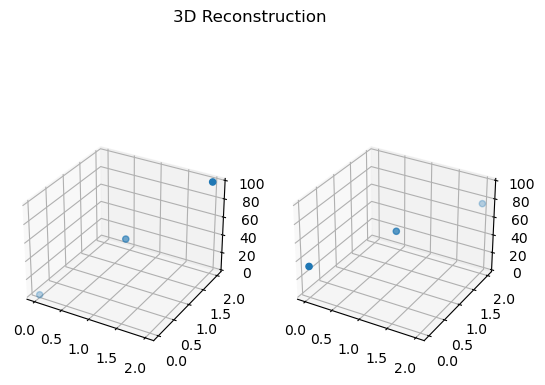

In [8]:
#Input data
in_array = np.array([(1,0,0),(0,50,0),(0,0,100)])
value_flow_test(in_array)

# Note how the tof returned is half scaled!! seems that the network thinks the difference bewteen point at 1 and point at 100 have seperation of approx 50 ~ this is consistent with the scale factor we used to norm the data, so it seems the renorm is not spreading the values back out properly? 

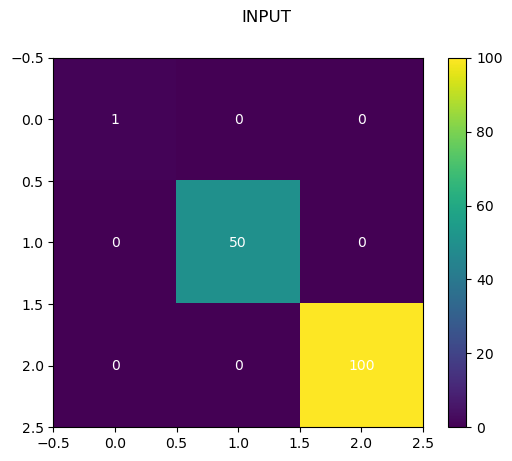

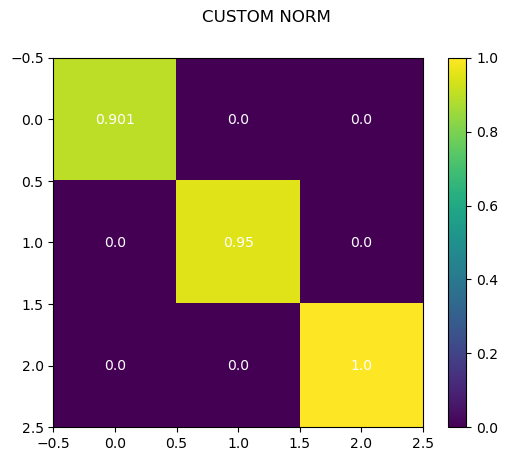

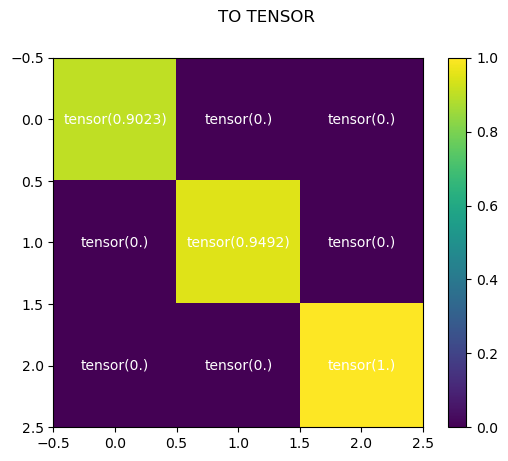

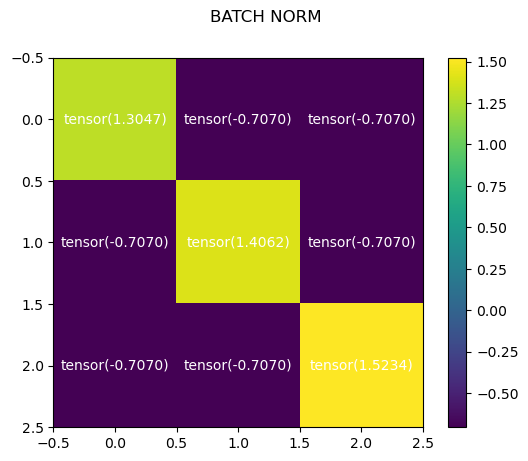

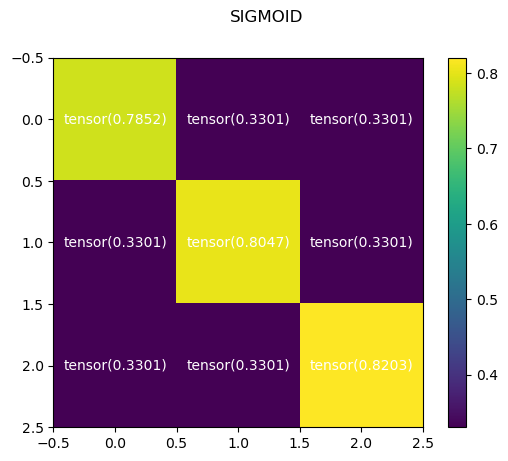

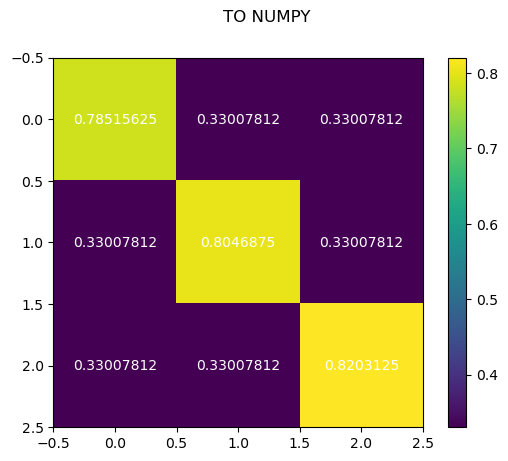

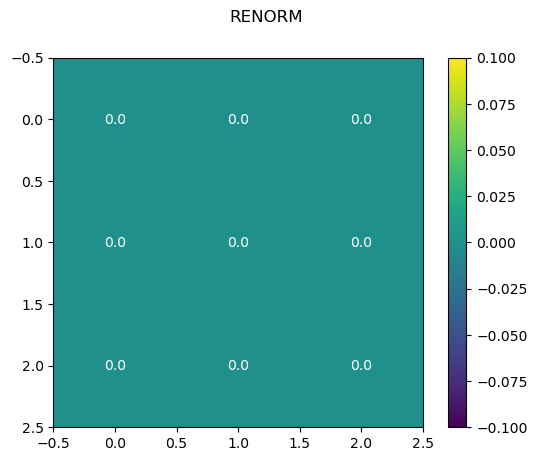

TypeError: Invalid shape (0,) for image data

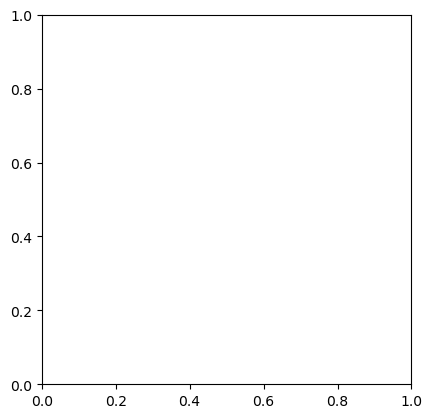

In [9]:
#Input data
in_array = np.array([(1,0,0),(0,50,0),(0,0,100)])
value_flow_test(in_array, reconstruction_threshold = 0.9)

# I belive the above is what is happening to us in that the data falls short of the reconstruction threshold (there is no error in main code beacuse we have a conditional to only plot reconstruction if there is data points to plot)

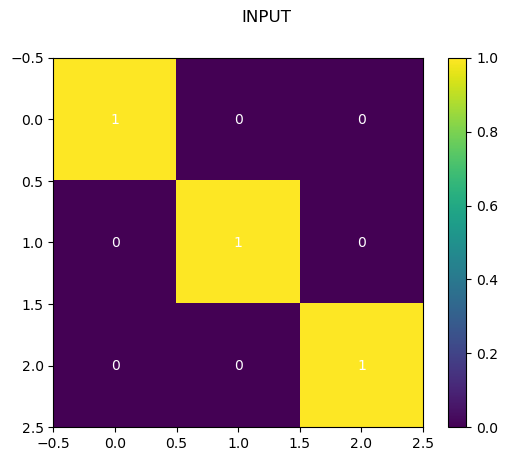

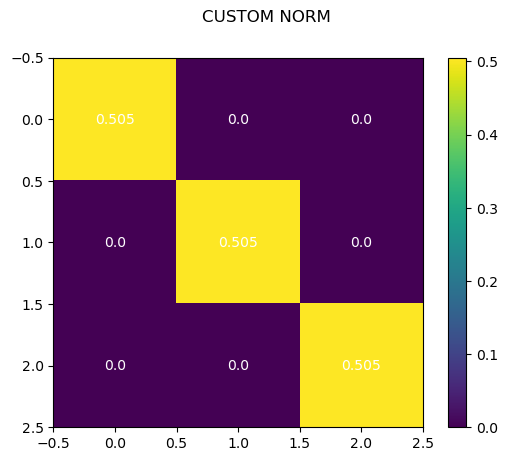

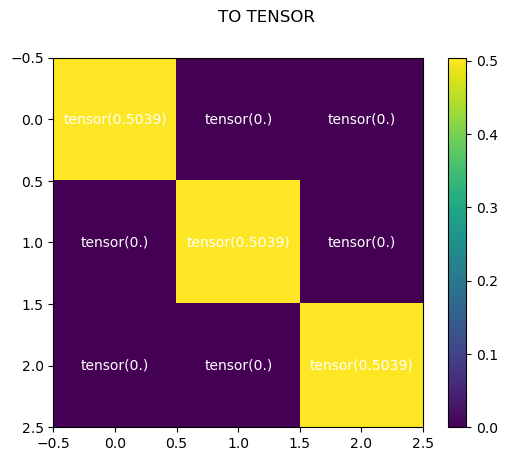

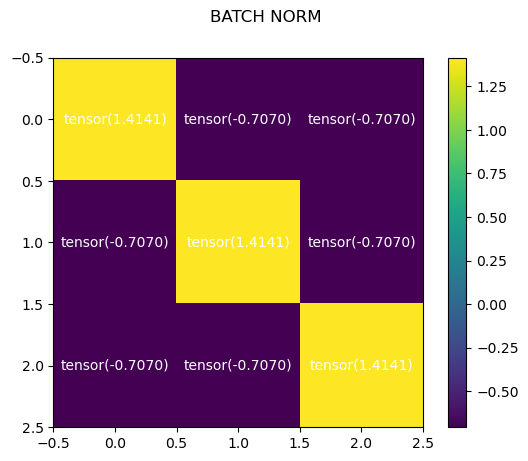

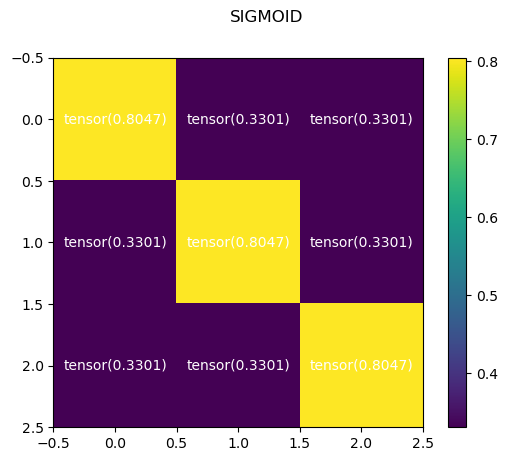

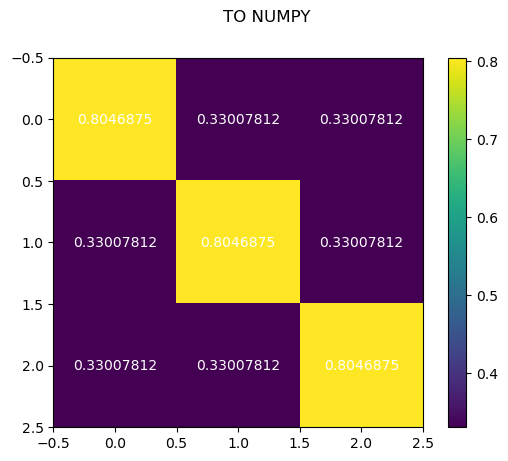

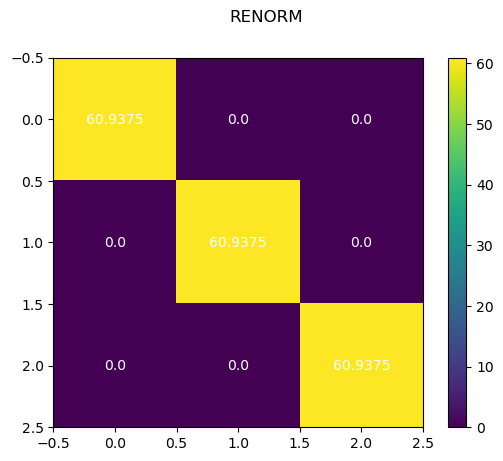

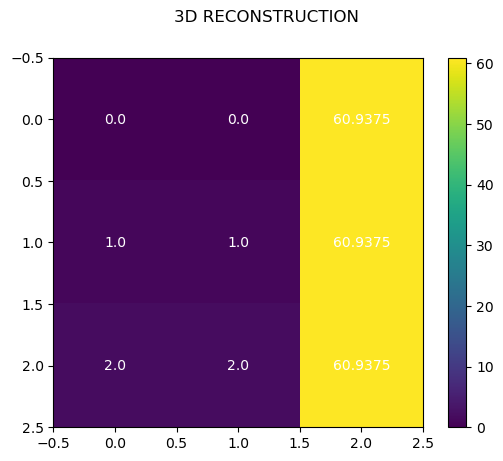

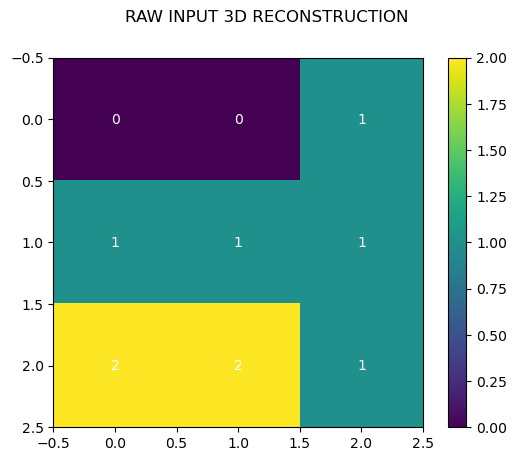

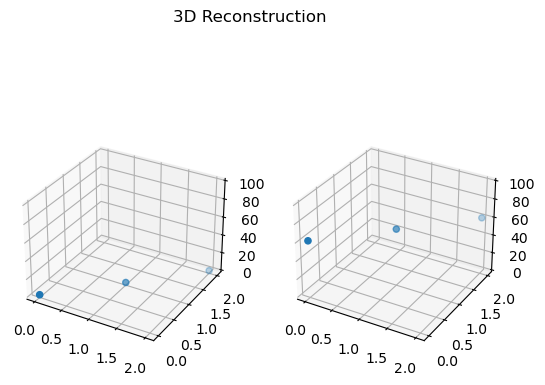

In [10]:
in_array = np.array([(1,0,0),(0,1,0),(0,0,1)])
value_flow_test(in_array)

# Interesting, in this example i pass value of 1 into the system and it comes out around 60, when earlier passing 1, 50, 100 the point for 50 had the same kind of height. The normalisation in the batch norm seems to be dependent on the batch itself and therfore scales the data, this is a problem for our tof.

# Perhaps an idea would be to set two particular pixels in each image to min (0) and max(time_dimension) values on its way into the AE so that every single image has the same max and min? may help the normalisation not move the data dissimilarly? althohj tbf have already seen eveidence that it is based on the distribution of the batch pixels rather than abasoloute min max so perhaps this will not be effective.

In [34]:

def generate_random_line(xdim, ydim, time_dimension):
    
    # Generate array of zeros
    arr = np.zeros((ydim, xdim, time_dimension))

    # Generate two random points
    point1 = (np.random.randint(0, ydim), np.random.randint(0, xdim), np.random.randint(0, time_dimension))
    point2 = (np.random.randint(0, ydim), np.random.randint(0, xdim), np.random.randint(0, time_dimension))

    # Make sure point1 is the point with the smaller coordinates
    point1, point2 = tuple(sorted([point1, point2]))

    # Add 1 to all the points between point1 and point2
    arr[point1[0]:point2[0]+1, point1[1]:point2[1]+1, point1[2]:point2[2]+1] = 1
    
    return arr

arr13 = generate_random_line(5, 5, 1)


In [35]:

def generatexyz(pixel_block_3d, reconstruction_threshold): 
    hits_3d = np.argwhere(pixel_block_3d.squeeze() >= reconstruction_threshold)    
    noh = (np.shape(hits_3d)[0])
    x3d = hits_3d[:,2]
    y3d = hits_3d[:,1]
    z3d = hits_3d[:,0]
    return (x3d, y3d, z3d)

In [36]:
print(arr13)
recondata = generatexyz(arr13, 0.5)
time_dimension = 100
print(recondata)
fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax1.scatter(recondata[0], recondata[1], recondata[2])
ax1.set_zlim(0, time_dimension)
fig.suptitle("3D Reconstruction")
plt.show()


[[[0.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[0.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[0.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[0.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]]]


IndexError: index 2 is out of bounds for axis 1 with size 2